In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision.transforms as T
from torchvision import datasets
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

from collections import OrderedDict

from livelossplot import PlotLosses
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

/home/shubham/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SOS = 10

transform = T.Compose([
                        T.Resize(128),
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
svhn_path = "/home/shubham/SVHN/"
svhn_train = datasets.SVHN(svhn_path, download=False, transform=transform)
svhn_trainloader = DataLoader(svhn_train, shuffle=True, batch_size=1)

0
(32, 32)


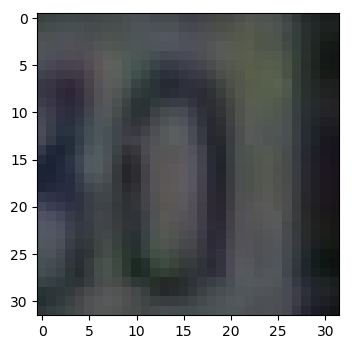

In [4]:
def see_example():
    svhn_path = "/home/shubham/SVHN/"
    svhn_train = datasets.SVHN(svhn_path, download=False)
    image, caption = svhn_train[2000]
    plt.imshow(image)
    print caption
    print image.size
see_example()

In [5]:
def SubModel(model, layers):
    return nn.Sequential(*list(model.children())[:layers])

In [6]:
model = models.squeezenet1_0(pretrained=False)
sqnet = model.features

/home/shubham/anaconda2/lib/python2.7/site-packages/torchvision-0.2.1-py2.7.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/shubham/anaconda2/lib/python2.7/site-packages/torchvision-0.2.1-py2.7.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [7]:
images, captions = next(iter(svhn_trainloader))
out = sqnet(images)
out.shape

torch.Size([1, 512, 7, 7])

## MLP to calculate initial hidden state for the attention RNN

In [20]:
class Hidden(nn.Module):
    def __init__(self, hidden_size, feature_size = (512,7*7)):
        super(Hidden, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(self.feature_size[0], 256)
        self.fc2 = nn.Linear(256, self.hidden_size)
        
    def forward(self, input):
        input_fc1 = input.view(self.feature_size[0],-1)
        input_fc1 = torch.mean(input_fc1, 1)
        out1 = F.relu(self.fc1(input_fc1))
        out2 = F.log_softmax(self.fc2(out1),dim=0)
        return out2, input

In [22]:
## sequential check
model = nn.Sequential(OrderedDict([
    ('features',sqnet),
    ('initHidden',Hidden(10))
]))
model(images)[0]

tensor([-2.3014, -2.2957, -2.2620, -2.2518, -2.3486, -2.3624, -2.2942, -2.2695,
        -2.3055, -2.3409], grad_fn=<LogSoftmaxBackward>)

Train classifier model with normal convnet

In [31]:
model = models.squeezenet1_0(pretrained=False)
model.classifier[1] = nn.Conv2d(512,10,kernel_size=(1,1), stride=(1,1))
model(images)

RuntimeError: Given input size: (10x7x7). Calculated output size: (10x-5x-5). Output size is too small at /opt/conda/conda-bld/pytorch_1535488076166/work/aten/src/THNN/generic/SpatialAveragePooling.c:64

In [ ]:

loss = nn.NLLLoss()
opti = optim.Adam(model.parameters())

liveloss = PlotLosses()
for data,target in svhn_trainloader:
    opti.zero_grad()
    output, _ = model(data)
    
    loss_ = loss(output.view(1,-1), target)
    liveloss.update({'log_loss':loss_})
    liveloss.draw()
    loss_.backward()
    opti.step()

# Attention decoder model

In [10]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, embedding_size = 32, vocab_size = 12, dropout_p = 0.2, feature_size=(512,7*7)):
        super(AttnDecoder, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.dropout_p = dropout_p
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.attn = nn.Linear(self.embedding_size + self.hidden_size, self.feature_size[0])
        self.attn_combine = nn.Linear(self.embedding_size + self.feature_size[1], self.embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        embedded = self.embedding(input).view(1,-1)
        embedded = self.dropout(embedded)
        
        hidden = hidden.view(1,1,-1)
        attn_weights = F.log_softmax(self.attn(torch.cat((embedded,hidden[0]),1)),dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_output)
        
        output = torch.cat((embedded, attn_applied[0]),1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output , hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

In [11]:
hidden, encoder_outputs = model(images)
encoder_outputs.shape

torch.Size([1, 512, 7, 7])

In [24]:
attndecoder = AttnDecoder(32)
attndecoder(torch.LongTensor([10]),hidden, encoder_outputs.view(1,512,-1))[0].shape

torch.Size([1, 12])

In [13]:
SOS = torch.LongTensor([10]) #Start of Sentence
EOS = torch.LongTensor([11]) #End of Sentence

In [14]:
def train(image, caption, encoder, decoder, encoder_optim, decoder_optim,loss_fn):
    """
    image -> transformed input image
    caption -> tuple of 3 numbers [SOS , caption, EOS]
    """
    
    loss = 0
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
    
    hidden, encoder_output = encoder(image)
    encoder_output = encoder_output.view(1,512,-1)
    
    outputs = []
    
    for i in range(len(caption)-1):
        output, hidden, attn_weights = decoder(caption[i], hidden, encoder_output)
        outputs.append(torch.argmax(output,dim=1))
        
        loss += loss_fn(output, caption[i+1])
    predicted_output = outputs[0]
    
    loss.backward()
    encoder_optim.step()
    decoder_optim.step()
    
    return loss , predicted_output

In [15]:
hidden_size = 32
encoder = nn.Sequential(OrderedDict([
    ('features',sqnet),
    ('initHidden',Hidden(hidden_size))
]))
decoder = AttnDecoder(hidden_size)

In [16]:
image,caption = next(iter(svhn_trainloader))
caption = [SOS, caption, EOS]

encoder_optim = optim.Adam(encoder.parameters())
decoder_optim = optim.Adam(decoder.parameters())
loss_fn = nn.NLLLoss()

train(image, caption, encoder, decoder, encoder_optim, decoder_optim,loss_fn)

(tensor(4.5839, grad_fn=<ThAddBackward>), tensor([2]))

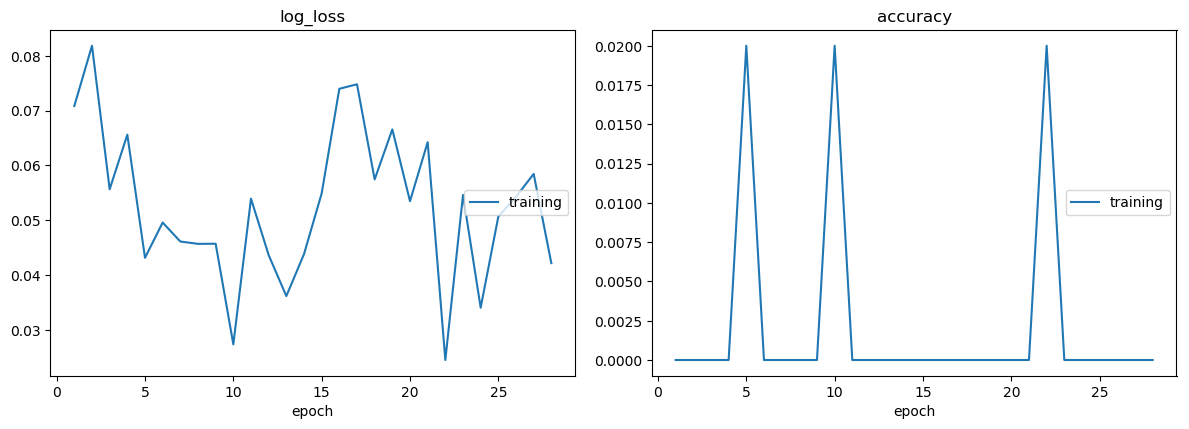

KeyboardInterrupt: 

In [17]:
liveloss = PlotLosses()
batch = 50
encoder.train()
decoder.train()
for epoch in range(1,10000):
    
    loss_t = 0
    correct = 0
    image, caption = next(iter(svhn_trainloader))
    caption = [SOS, caption, EOS]
    encoder_optim = optim.Adam(encoder.parameters())
    decoder_optim = optim.Adam(decoder.parameters())
    loss_fn = nn.NLLLoss()
    
    loss, output = train(image, caption, encoder, decoder, encoder_optim, decoder_optim,loss_fn)
    
    correct+= (output == caption[1])[0].numpy()
    loss_t += loss
    if epoch % batch == 0:
        loss_avg = loss_t / float(batch)
        loss_t = 0
        correct_avg = correct / float(batch)
        liveloss.update({'log_loss':loss_avg, 'accuracy':correct_avg})
        liveloss.draw()
        loss_avg = 0
        correct=0